In [6]:
import numpy as np
from gene import *
import matplotlib.pyplot as plt 

# 1. Plot D

Smallest value 1.1293081758287165 when D is:0.4


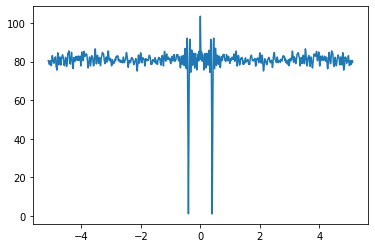

In [44]:
T = np.random.random((1000, 1))*100
T = np.tile(T, (1, 1024))
b2 = F2(T, 0.6, 1.2, 100, 0.4)
A = np.full((1000, 1024), 0.6)
B = np.full((1000, 1024), 1.2)
C = np.full((1000, 1024), 100)
D = np.tile(np.arange(-5.11, 5.13, 0.01), (1000, 1))
y = np.mean(abs(F2(T, A, B, C, D) - b2), axis=0)
# print(np.argmin(y))
smallest_d = round(D[0][np.argmin(y)], 2)
smallest_val = np.mean(abs(F2(T, 0.6, 1.2, 100, smallest_d) - b2))
print(f"Smallest value {smallest_val} when D is:{smallest_d}")
plt.plot(D[0], y)


# 2. Plot A C

Smallest value 1.1148292525241397 when A is:0.599999999999878, C is 100


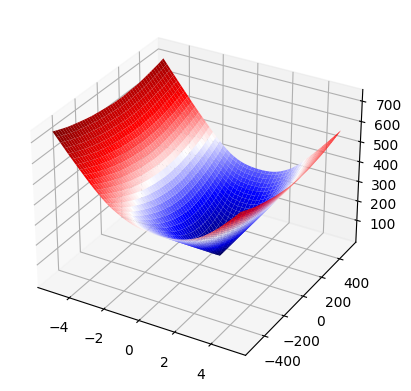

In [9]:
t_shape = (1000, 1024*1024)
T = np.random.random((1000, 1))*100
#T = np.tile(T, (1, 1024, 1024))
b2 = F2(T, 0.6, 1.2, 100, 0.4)
X = np.arange(-5.11, 5.13, 0.01)
Y = np.arange(-511, 513, 1)
X, Y = np.meshgrid(X, Y)
#print(X.shape)
#print(Y.shape)
Z = np.empty((1024, 1024))
#print(Z.shape)
for i in range(1024):
    for j in range(1024):
        ans = F2(T, X[i, j], 1.2, Y[i, j], 0.4)
        Z[i, j] = np.mean(abs(ans - b2))
x, y = np.unravel_index(Z.argmin(), Z.shape)
smallest_val = np.mean(abs(F2(T, X[x, y], 1.2, Y[x, y], 0.4) - b2))
print(f"Smallest value {smallest_val} when A is:{X[x, y]}, C is {Y[x, y]}")
"""
A = np.tile(X, (1000, 1))
B = np.full(t_shape, 1.2)
C = np.tile(Y, (1000, 1))
D = np.full(t_shape, 0.4)
y = np.mean(abs(F2(T, A, B, C, D) - b2), axis=0)
"""
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap="seismic")
plt.show()


# 3. Stock price modeling

In [26]:
import pandas as pd

In [122]:
def F(t, A, B, C, tc, beta, omega, fi):
    return A + B * (tc - t)**beta * (1 + C*np.cos(omega*np.log(tc - t) + fi))

def gene2coef_stock(gene):
    tc = (np.sum(2**np.arange(2)*gene[0:2])) + 731   #731 - 734
    beta = (np.sum(2**np.arange(8)*gene[2:10])) / 257 + 1/257   #0 - 1
    omega = (np.sum(2**np.arange(10)*gene[10:20])) / 1023 * 7 + 6   #6 - 13
    fi = (np.sum(2**np.arange(10)*gene[20:30])) / 1023 * 2*np.pi   #0 - 2pi
    return tc, beta, omega, fi

def fitness_eval_stock(N, T, b2, pop):
    fit = np.empty((pop.shape[0], 1))
    #print("T size", T.shape)
    Arr = np.zeros((734, 3))
    for i in range(N):
        #print(len(pop.shape))
        tc, beta, omega, fi = gene2coef_stock(pop[i, :])

        # Solve LP
        l = len(T)
        #print("tc:", tc)
        for j in range(tc):
            Arr[j, 0] = 1
            Arr[j, 1] = (tc-T[j])**beta
            Arr[j, 2] = (tc-T[j])**beta * np.cos(omega*np.log(tc - T[j]) + fi)
        b = b2[:tc, :]
        #print("Arr size", Arr[:tc].shape)
        #print("b2 size", b2.shape)
        A, B, C = np.linalg.lstsq(Arr[:tc, :], b)[0]
        C =  C / B
        # compute fitness
        T_copy = T[:tc, :]
        fit[i, 0] = np.mean(abs(F(T_copy, A, B, C, tc, beta, omega, fi) - b))

    return fit



In [123]:
def gene_algo_stock(b2):
    b2 = np.log(b2)
    T = np.arange(len(b2)).reshape(-1, 1)
    gene_len = 30

    N = 10000
    G = 30
    survive_rate = 0.05
    mutation_rate = 0.001
    survive = round(N*survive_rate)
    mutation = round(N*gene_len*mutation_rate)

    pop = np.random.randint(0, 2, (N, gene_len))
    fit = np.zeros((N, 1))

    for generation in range(G):
    
        # fitness
        #print(len(pop.shape))
        fit = fitness_eval_stock(N, T, b2, pop)
        
        #selection
        sortf = np.argsort(fit[:, 0])
        pop = pop[sortf, :]
        for i in range(survive, N):
            fid = np.random.randint(0, survive)
            mid = np.random.randint(0, survive)
            while(fid==mid):
                mid = np.random.randint(0, survive) # mother should different from father
            mask = np.random.randint(0, 2, [1, gene_len])
            son = pop[mid, :].copy()
            father = pop[fid, :]
            son[mask[0, :]==1] = father[mask[0, :]==1]   # crossover
            pop[i, :] = son
        
        # mutation
        for i in range(mutation):
            m = np.random.randint(survive, N)
            n = np.random.randint(0, gene_len)
            pop[m, n] = 1 - pop[m, n]
        #print("pop shape:", pop.shape)
        #fitness
        fit = fitness_eval_stock(N, T, b2, pop)
    
    sortf = np.argsort(fit[:, 0])
    pop = pop[sortf, :]
    
    tc, beta, omega, fi = gene2coef_stock(pop[0, :])

    # Solve LP
    l = len(T)
    Arr = np.zeros((tc, 3))
    for j in range(tc):
        Arr[j, 0] = 1
        Arr[j, 1] = (tc-T[j])**beta
        Arr[j, 2] = (tc-T[j])**beta * np.cos(omega*np.log(tc - T[j]) + fi)
    b2 = b2[:tc, :]
    A, B, C = np.linalg.lstsq(Arr, b2)[0]
    C =  C / B
    T = T[:tc]
    print(f"A: {A}, B: {B}, C: {C}, tc: {tc}, beta: {beta}, omega: {omega}, phi: {fi}")
    predicted = np.exp(F(T, A, B, C, tc, beta, omega, fi))
    return tc, predicted

In [124]:
df = pd.read_csv('NVDA.csv', usecols=['Close'])
close = df['Close'].to_numpy().reshape(-1, 1)
b2 = close
tc, predicted = gene_algo_stock(b2)

C:\Users\panda\AppData\Local\Temp\ipykernel_1632\2406112178.py:29: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, B, C = np.linalg.lstsq(Arr[:tc, :], b)[0]


A: [5.52805217], B: [-0.0028954], C: [-0.13409926], tc: 731, beta: 0.9961089494163424, omega: 6.0, phi: 3.599165777133175


C:\Users\panda\AppData\Local\Temp\ipykernel_1632\574699084.py:58: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  A, B, C = np.linalg.lstsq(Arr, b2)[0]


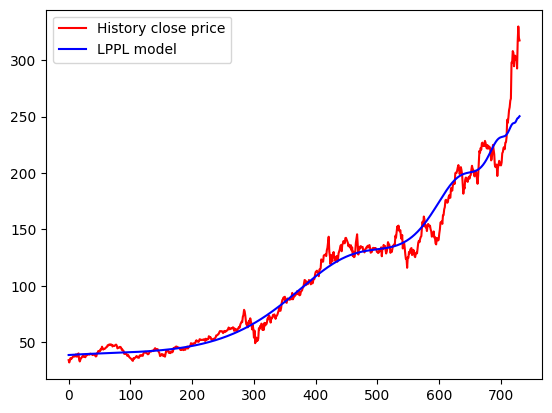

In [ ]:
# plot 
predicted = predicted[:tc]
close = close[:tc]
print(np.sum(np.abs(predicted - close)))
plt.plot(range(tc), close, 'r-', range(tc), predicted, 'b-')
plt.legend(['History close price', 'LPPL model'])